# Reddit Posts Analysis with Natural Language Processing

# Part 3

*Content:*

1. [Model Preparation](#Model-Preparation)
2. [Modeling](#Modeling)
3. [Evaluation](#Evaluation)
4. [Analysis of Final Model](#Analysis-of-Final-Model)
5. [Additional References](#Additional-References)
6. [Limitations](#Limitations)
7. [Conclusion](#Conclusion)
8. [Recommendations](#Recommendations)

*Other notebooks:* 
- [Part 1: Web Scraping](Part_1_Reddit_Analysis_WebScraping.ipynb)
- [Part 2: Data Cleaning & EDA](Part_2_Reddit_Analysis_EDA.ipynb)
- [Part 3: Modeling & Evaluation](Part_3_Reddit_Analysis_Modeling.ipynb)

## Model Preparation

### Libraries

In [1]:
import numpy as np
import statistics
import pandas as pd
import datetime 
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_rows = 110
pd.options.display.max_colwidth = 1000

### Loading the dataset

In [2]:
pets_df = pd.read_csv('../datasets/pets_preprocessed.csv')

In [3]:
pets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_cat        4099 non-null   int64 
 1   title         4099 non-null   object
 2   selftext      4099 non-null   object
 3   joined_text   4099 non-null   object
 4   cleaned_text  4094 non-null   object
dtypes: int64(1), object(4)
memory usage: 160.2+ KB


In [4]:
pets_df['cleaned_text'] = pets_df['cleaned_text'].astype('U').values

### Train/Test Split

In [5]:
# Identify feature and target
# convert X column into unicode

X = pets_df['cleaned_text']
y = pets_df['is_cat']

In [6]:
# Setting up train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 10)

In [7]:
# See train and test dataset shape

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3279,)
(3279,)
(820,)
(820,)


### Model Preparation

In [8]:
# Instantiate a CountVectorizer
cvec = CountVectorizer()

# Fit the vectorizer on our corpus
cvec.fit(X_train)

# Transform the corpus
X_train_cvec = cvec.transform(X_train)

# Transform the test
X_test_cvec = cvec.transform(X_test)

In [9]:
# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names())
X_train_df.head()

,aa,aafco,ab,abandon,abandoned,abandoning,abandonment,abdomen,abdominal,abhorrent,...,zooming,zooms,zora,zuby,zucchini,zuchon,zuzu,zvrg,zwbigtgs,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have over 10,000 words in the vocabulary.

## Modeling

### Baseline Model

In [10]:
pets_df['is_cat'].value_counts(normalize=True)

1    0.669919
0    0.330081
Name: is_cat, dtype: float64

We're setting our baseline model at 67% accuracy in predicting that a post is a cat-related issue. We'll aim to test a few models that can outperform this score.

In our modeling process, we'll be using two main vectorization methods: Count Vectorizer and Term Frequency-Inverse Document Frequency (TF-IDF). 

We'll be modeling our data against four main models: Logistic Regression, Naive Bayes, Random Forest and Adaptive Boosting.

Based on the results, we'll identify the best model that would predict cat vs dog topics.

### CountVectorizer & Logistic Regression 

In [11]:
# set a pipeline up with two stages:
# 1. CountVectorizer (vectorizer)
# 2. LogisticRegression (model)

pipe_1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000,
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check unigrams and bigrams

params_1 = {
    'cvec__max_features' : [5_000, 10_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs1 = GridSearchCV(pipe_1, param_grid = params_1, cv = 5)

In [12]:
# Fit GridSearch to training data

gs1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [13]:
# Calculate the best score

gs1.best_score_

0.8282996648668777

In [14]:
# Identify best parameters

gs1.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [15]:
# Saving this model for prediction

gs1_model = gs1.best_estimator_

In [16]:
cv_lr_score_train = gs1_model.score(X_train, y_train)
print(f'Training score is {cv_lr_score_train}')

cv_lr_score_test = gs1_model.score(X_test, y_test)
print(f'Test score is {cv_lr_score_test}')

Training score is 0.9685879841415066
Test score is 0.8268292682926829


In [17]:
y_pred_1 = gs1.predict(X_test)

In [18]:
cv_lr_f1 = f1_score(y_test, y_pred_1)
print(f'F1 score is {cv_lr_f1}')

cv_lr_prec = precision_score(y_test, y_pred_1)
print(f'Precision score is {cv_lr_prec}')

cv_lr_acc = accuracy_score(y_test, y_pred_1)
print(f'Accuracy score is {cv_lr_acc}')

cv_lr_rec = recall_score(y_test, y_pred_1)
print(f'Recall score is {cv_lr_rec}')

cv_lr_roc = roc_auc_score(y_test, y_pred_1)
print(f'ROC score is {cv_lr_roc}')

F1 score is 0.876736111111111
Precision score is 0.8374792703150912
Accuracy score is 0.8268292682926829
Recall score is 0.9198542805100182
ROC score is 0.779115332136928


In [19]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       271
           1       0.84      0.92      0.88       549

    accuracy                           0.83       820
   macro avg       0.82      0.78      0.79       820
weighted avg       0.82      0.83      0.82       820



In [20]:
confusion_matrix(y_test, y_pred_1)

array([[173,  98],
       [ 44, 505]])

### TFIDF & Logistic Regression

In [21]:
# set a pipeline up with two stages:
# 1. TF-IDF / term frequency–inverse document frequency (vectorizer)
# 2. LogisticRegression (model)

pipe_2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000,
# Check unigrams and bigrams

params_2 = {
    'tf__max_features' : [1_000, 5_000, 10_000],
    'tf__ngram_range' : [(1,1), (2,2)]
}

# Instantiate GridSearchCV

gs2 = GridSearchCV(pipe_2, param_grid = params_2, cv = 5)

In [22]:
# Fit GridSearch to training data

gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tf__max_features': [1000, 5000, 10000],
                         'tf__ngram_range': [(1, 1), (2, 2)]})

In [23]:
# Calculate the best score

gs2.best_score_

0.8160998882889592

In [24]:
# Saving this model for prediction

gs2_model = gs2.best_estimator_

In [25]:
tfidf_lr_score_train = gs2_model.score(X_train, y_train)
print(f'Training score is {tfidf_lr_score_train}')

tfidf_lr_score_test = gs2_model.score(X_test, y_test)
print(f'Test score is {tfidf_lr_score_test}')

Training score is 0.902714242146996
Test score is 0.824390243902439


In [26]:
y_pred_2 = gs2.predict(X_test)

In [27]:
tfidf_lr_f1 = f1_score(y_test, y_pred_2)
print(f'F1 score is {tfidf_lr_f1}')

tfidf_lr_prec = precision_score(y_test, y_pred_2)
print(f'Precision score is {tfidf_lr_prec}')

tfidf_lr_acc = accuracy_score(y_test, y_pred_2)
print(f'Accuracy score is {tfidf_lr_acc}')

tfidf_lr_rec = recall_score(y_test, y_pred_2)
print(f'Recall score is {tfidf_lr_rec}')

tfidf_lr_roc = roc_auc_score(y_test, y_pred_2)
print(f'ROC score is {tfidf_lr_roc}')

F1 score is 0.8801996672212978
Precision score is 0.8101071975497703
Accuracy score is 0.824390243902439
Recall score is 0.9635701275045537
ROC score is 0.7530027759293987


In [28]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67       271
           1       0.81      0.96      0.88       549

    accuracy                           0.82       820
   macro avg       0.85      0.75      0.78       820
weighted avg       0.83      0.82      0.81       820



In [29]:
confusion_matrix(y_test, y_pred_2)

array([[147, 124],
       [ 20, 529]])

### CountVectorizer & Naive Bayes

In [30]:
# Set a pipeline up with two stages:
# 1. CountVectorizer (vectorizer)
# 2. Naive Bayes (model)

pipe_3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check unigrams and bigrams

params_3 = {
    'cvec__max_features' : [5_000, 10_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs3 = GridSearchCV(pipe_3, param_grid = params_3, cv=5) 

In [31]:
# Fit GridSearch to training data

gs3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [32]:
# Calculate the best score

gs3.best_score_

0.8462888661329361

In [33]:
gs3.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [34]:
# Saving this model for prediction

gs3_model = gs3.best_estimator_

In [35]:
cv_nb_score_train = gs3_model.score(X_train, y_train)
print(f'Training score is {cv_nb_score_train}')

cv_nb_score_test = gs3_model.score(X_test, y_test)
print(f'Test score is {cv_nb_score_test}')

Training score is 0.9063738944800244
Test score is 0.8585365853658536


In [36]:
y_pred_3 = gs3.predict(X_test)

In [37]:
cv_nb_f1 = f1_score(y_test, y_pred_3)
print(f'F1 score is {cv_nb_f1}')

cv_nb_prec = precision_score(y_test, y_pred_3)
print(f'Precision score is {cv_nb_prec}')

cv_nb_acc = accuracy_score(y_test, y_pred_3)
print(f'Accuracy score is {cv_nb_acc}')

cv_nb_rec = recall_score(y_test, y_pred_3)
print(f'Recall score is {cv_nb_rec}')

cv_nb_roc = roc_auc_score(y_test, y_pred_3)
print(f'ROC score is {cv_nb_roc}')

F1 score is 0.8939670932358319
Precision score is 0.8972477064220183
Accuracy score is 0.8585365853658536
Recall score is 0.8907103825136612
ROC score is 0.8420341580464985


In [38]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       271
           1       0.90      0.89      0.89       549

    accuracy                           0.86       820
   macro avg       0.84      0.84      0.84       820
weighted avg       0.86      0.86      0.86       820



In [39]:
confusion_matrix(y_test, y_pred_3)

array([[215,  56],
       [ 60, 489]])

### TF-IDF & Naive Bayes

In [40]:
# Set a pipeline up with two stages:
# 1. CountVectorizer (vectorizer)
# 2. Naive Bayes (model)

pipe_4 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000,
# Check unigrams and bigrams

params_4 = {
    'tf__max_features' : [5_000,10_000],
    'tf__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs4 = GridSearchCV(pipe_4, param_grid = params_4, cv=5) 

In [41]:
# Fit GridSearch to training data

gs4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [5000, 10000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [42]:
# Calculate the best score

gs4.best_score_

0.7840783839136102

In [43]:
gs4.best_params_

{'tf__max_features': 5000, 'tf__ngram_range': (1, 2)}

In [44]:
# Saving this model for prediction

gs4_model = gs4.best_estimator_

In [45]:
tfidf_nb_score_train = gs4_model.score(X_train, y_train)
print(f'Training score is {tfidf_nb_score_train}')

tfidf_nb_score_test = gs4_model.score(X_test, y_test)
print(f'Test score is {tfidf_nb_score_test}')

Training score is 0.8789265019823117
Test score is 0.7963414634146342


In [46]:
y_pred_4 = gs4.predict(X_test)

In [47]:
tfidf_nb_f1 = f1_score(y_test, y_pred_4)
print(f'F1 score is {tfidf_nb_f1}')

tfidf_nb_prec = precision_score(y_test, y_pred_4)
print(f'Precision score is {tfidf_nb_prec}')

tfidf_nb_acc = accuracy_score(y_test, y_pred_4)
print(f'Accuracy score is {tfidf_nb_acc}')

tfidf_nb_rec = recall_score(y_test, y_pred_4)
print(f'Recall score is {tfidf_nb_rec}')

tfidf_nb_roc = roc_auc_score(y_test, y_pred_4)
print(f'ROC score is {tfidf_nb_roc}')

F1 score is 0.8649959579628133
Precision score is 0.7776162790697675
Accuracy score is 0.7963414634146342
Recall score is 0.9744990892531876
ROC score is 0.704961721748365


In [48]:
print(classification_report(y_test, y_pred_4))

              precision    recall  f1-score   support

           0       0.89      0.44      0.59       271
           1       0.78      0.97      0.86       549

    accuracy                           0.80       820
   macro avg       0.84      0.70      0.73       820
weighted avg       0.82      0.80      0.77       820



In [49]:
confusion_matrix(y_test, y_pred_4)

array([[118, 153],
       [ 14, 535]])

### Count Vectorizer & Random Forest

In [50]:
# Set a pipeline up with two stages:
# 1. CountVectorizer (vectorizer)
# 2. Random Forest (model)

pipe_5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check unigrams and bigrams

params_5 = {
    'cvec__max_features' : [5_000, 10_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs5 = GridSearchCV(pipe_5, param_grid = params_5, cv=5) 

In [51]:
# Fit GridSearch to training data

gs5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [52]:
# Calculate the best score

gs5.best_score_

0.8389769130515733

In [53]:
# Saving this model for prediction

gs5_model = gs5.best_estimator_

In [54]:
cv_rf_score_train = gs5_model.score(X_train, y_train)
print(f'Training score is {cv_rf_score_train}')

cv_rf_score_test = gs5_model.score(X_test, y_test)
print(f'Test score is {cv_rf_score_test}')

Training score is 0.9984751448612382
Test score is 0.8402439024390244


In [55]:
y_pred_5 = gs5.predict(X_test)

In [56]:
cv_rf_f1 = f1_score(y_test, y_pred_5)
print(f'F1 score is {cv_rf_f1}')

cv_rf_prec = precision_score(y_test, y_pred_5)
print(f'Precision score is {cv_rf_prec}')

cv_rf_acc = accuracy_score(y_test, y_pred_5)
print(f'Accuracy score is {cv_rf_acc}')

cv_rf_rec = recall_score(y_test, y_pred_5)
print(f'Recall score is {cv_rf_rec}')

cv_rf_roc = roc_auc_score(y_test, y_pred_5)
print(f'ROC score is {cv_rf_roc}')

F1 score is 0.8843777581641661
Precision score is 0.8578767123287672
Accuracy score is 0.8402439024390244
Recall score is 0.912568306010929
ROC score is 0.8031476216401507


In [57]:
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       271
           1       0.86      0.91      0.88       549

    accuracy                           0.84       820
   macro avg       0.83      0.80      0.81       820
weighted avg       0.84      0.84      0.84       820



In [58]:
confusion_matrix(y_test, y_pred_5)

array([[188,  83],
       [ 48, 501]])

### TF-IDF & Random Forest

In [59]:
# set a pipeline up with two stages:
# 1. TF-IDF / term frequency–inverse document frequency (vectorizer)
# 2. Random Forest (model)

pipe_6 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('rf', RandomForestClassifier())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000,
# Check unigrams and bigrams

params_6 = {
    'tf__max_features' : [1_000, 5_000, 10_000],
    'tf__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs6 = GridSearchCV(pipe_6, param_grid = params_6, cv = 5)

In [60]:
# Fit GridSearch to training data

gs6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'tf__max_features': [1000, 5000, 10000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [61]:
# Calculate the best score

gs6.best_score_

0.8374520573450009

In [62]:
# Saving this model for prediction

gs6_model = gs6.best_estimator_

In [63]:
tfidf_rf_score_train = gs6_model.score(X_train, y_train)
print(f'Training score is {tfidf_rf_score_train}')

tfidf_rf_score_test = gs6_model.score(X_test, y_test)
print(f'Test score is {tfidf_rf_score_test}')

Training score is 0.9975602317779811
Test score is 0.8402439024390244


In [64]:
y_pred_6 = gs6.predict(X_test)

In [65]:
tfidf_rf_f1 = f1_score(y_test, y_pred_6)
print(f'F1 score is {tfidf_rf_f1}')

tfidf_rf_prec = precision_score(y_test, y_pred_6)
print(f'Precision score is {tfidf_rf_prec}')

tfidf_rf_acc = accuracy_score(y_test, y_pred_6)
print(f'Accuracy score is {tfidf_rf_acc}')

tfidf_rf_rec = recall_score(y_test, y_pred_6)
print(f'Recall score is {tfidf_rf_rec}')

tfidf_rf_roc = roc_auc_score(y_test, y_pred_6)
print(f'ROC score is {tfidf_rf_roc}')

F1 score is 0.8851884312007012
Precision score is 0.8530405405405406
Accuracy score is 0.8402439024390244
Recall score is 0.9198542805100182
ROC score is 0.7994105350889574


In [66]:
print(classification_report(y_test, y_pred_6))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       271
           1       0.85      0.92      0.89       549

    accuracy                           0.84       820
   macro avg       0.83      0.80      0.81       820
weighted avg       0.84      0.84      0.84       820



In [67]:
confusion_matrix(y_test, y_pred_6)

array([[184,  87],
       [ 44, 505]])

### Count Vectorizer & Adaptive Boosting

In [68]:
# Set a pipeline up with two stages:
# 1. CountVectorizer (vectorizer)
# 2. Random Forest (model)

pipe_7 = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check unigrams and bigrams

params_7 = {
    'cvec__max_features' : [5_000, 10_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs7 = GridSearchCV(pipe_7, param_grid = params_7, cv=5) 

In [69]:
# Fit GridSearch to training data

gs7.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [70]:
# Calculate the best score

gs7.best_score_

0.8099958108359709

In [71]:
# Saving this model for prediction

gs7_model = gs7.best_estimator_

In [72]:
cv_ada_score_train = gs7_model.score(X_train, y_train)
print(f'Training score is {cv_ada_score_train}')

cv_ada_score_test = gs7_model.score(X_test, y_test)
print(f'Test score is {cv_ada_score_test}')

Training score is 0.8331808478194571
Test score is 0.8085365853658537


In [73]:
y_pred_7 = gs7.predict(X_test)

In [74]:
cv_ada_f1 = f1_score(y_test, y_pred_7)
print(f'F1 score is {cv_ada_f1}')

cv_ada_prec = precision_score(y_test, y_pred_7)
print(f'Precision score is {cv_ada_prec}')

cv_ada_acc = accuracy_score(y_test, y_pred_7)
print(f'Accuracy score is {cv_ada_acc}')

cv_ada_rec = recall_score(y_test, y_pred_7)
print(f'Recall score is {cv_ada_rec}')

cv_ada_roc = roc_auc_score(y_test, y_pred_7)
print(f'ROC score is {cv_ada_roc}')

F1 score is 0.8666100254885302
Precision score is 0.8121019108280255
Accuracy score is 0.8085365853658537
Recall score is 0.9289617486338798
ROC score is 0.7467686971951688


In [75]:
print(classification_report(y_test, y_pred_7))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66       271
           1       0.81      0.93      0.87       549

    accuracy                           0.81       820
   macro avg       0.80      0.75      0.76       820
weighted avg       0.81      0.81      0.80       820



In [76]:
confusion_matrix(y_test, y_pred_7)

array([[153, 118],
       [ 39, 510]])

### TF-IDF & Adaptive Boosting

In [77]:
# Set a pipeline up with two stages:
# 1. CountVectorizer (vectorizer)
# 2. Random Forest (model)

pipe_8 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000,
# Check unigrams and bigrams

params_8 = {
    'tf__max_features' : [1_000, 5_000, 10_000],
    'tf__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV

gs8 = GridSearchCV(pipe_8, param_grid = params_8, cv=5) 

In [78]:
# Fit GridSearch to training data

gs8.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'tf__max_features': [1000, 5000, 10000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [79]:
# Calculate the best score

gs8.best_score_

0.8057293800037237

In [80]:
# Saving this model for prediction

gs8_model = gs8.best_estimator_

In [81]:
tfidf_ada_score_train = gs8_model.score(X_train, y_train)
print(f'Training score is {tfidf_ada_score_train}')

tfidf_ada_score_test = gs8_model.score(X_test, y_test)
print(f'Test score is {tfidf_ada_score_test}')

Training score is 0.8441598048185422
Test score is 0.8085365853658537


In [82]:
y_pred_8 = gs8.predict(X_test)

In [83]:
tfidf_ada_f1 = f1_score(y_test, y_pred_8)
print(f'F1 score is {tfidf_ada_f1}')

tfidf_ada_prec = precision_score(y_test, y_pred_8)
print(f'Precision score is {tfidf_ada_prec}')

tfidf_ada_acc = accuracy_score(y_test, y_pred_8)
print(f'Accuracy score is {tfidf_ada_acc}')

tfidf_ada_rec = recall_score(y_test, y_pred_8)
print(f'Recall score is {tfidf_ada_rec}')

tfidf_ada_roc = roc_auc_score(y_test, y_pred_8)
print(f'ROC score is {tfidf_ada_roc}')

F1 score is 0.8656971770744226
Precision score is 0.8161290322580645
Accuracy score is 0.8085365853658537
Recall score is 0.9216757741347905
ROC score is 0.750505783746362


In [84]:
print(classification_report(y_test, y_pred_8))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       271
           1       0.82      0.92      0.87       549

    accuracy                           0.81       820
   macro avg       0.80      0.75      0.77       820
weighted avg       0.81      0.81      0.80       820



In [85]:
confusion_matrix(y_test, y_pred_8)

array([[157, 114],
       [ 43, 506]])

## Evaluation

In [86]:
results = pd.DataFrame(data=[["CountVectorizer", "Logistic Regression", cv_lr_score_train, cv_lr_score_test, cv_lr_f1, cv_lr_prec, cv_lr_acc, cv_lr_rec, cv_lr_roc],
                            ["TF-IDF", "Logistic Regression", tfidf_lr_score_train, tfidf_lr_score_test, tfidf_lr_f1, tfidf_lr_prec, tfidf_lr_acc, tfidf_lr_rec, tfidf_lr_roc],
                            ["CountVectorizer", "Naive Bayes", cv_nb_score_train, cv_nb_score_test, cv_nb_f1, cv_nb_prec, cv_nb_acc, cv_nb_rec, cv_nb_roc],
                            ["TF-IDF", "Naive Bayes", tfidf_nb_score_train, tfidf_nb_score_test, tfidf_nb_f1, tfidf_nb_prec, tfidf_nb_acc, tfidf_nb_rec, tfidf_nb_roc],
                            ["CountVectorizer", "Random Forest", cv_rf_score_train, cv_rf_score_test, cv_rf_f1, cv_rf_prec, cv_rf_acc, cv_rf_rec, cv_rf_roc],
                            ["TF-IDF", "Random Forest", tfidf_rf_score_train, tfidf_rf_score_test, tfidf_rf_f1, tfidf_rf_prec, tfidf_rf_acc, tfidf_rf_rec, tfidf_rf_roc],
                            ["CountVectorizer", "Adaptive Boosting", cv_ada_score_train, cv_ada_score_test, cv_ada_f1, cv_ada_prec, cv_ada_acc, cv_ada_rec, cv_ada_roc],
                            ["TF-IDF", "Adaptive Boosting", tfidf_ada_score_train, tfidf_ada_score_test, tfidf_ada_f1, tfidf_ada_prec, tfidf_ada_acc, tfidf_ada_rec, tfidf_ada_roc],],
                      columns=["Vectorizer", "Model", "Training Score", "Test Score", "F1 Score", "Precision", "Accuracy", "Recall", "ROC"])

results

,Vectorizer,Model,Training Score,Test Score,F1 Score,Precision,Accuracy,Recall,ROC
0,CountVectorizer,Logistic Regression,0.968588,0.826829,0.876736,0.837479,0.826829,0.919854,0.779115
1,TF-IDF,Logistic Regression,0.902714,0.824390,0.880200,0.810107,0.824390,0.963570,0.753003
2,CountVectorizer,Naive Bayes,0.906374,0.858537,0.893967,0.897248,0.858537,0.890710,0.842034
3,TF-IDF,Naive Bayes,0.878927,0.796341,0.864996,0.777616,0.796341,0.974499,0.704962
4,CountVectorizer,Random Forest,0.998475,0.840244,0.884378,0.857877,0.840244,0.912568,0.803148
5,TF-IDF,Random Forest,0.997560,0.840244,0.885188,0.853041,0.840244,0.919854,0.799411
6,CountVectorizer,Adaptive Boosting,0.833181,0.808537,0.866610,0.812102,0.808537,0.928962,0.746769
7,TF-IDF,Adaptive Boosting,0.844160,0.808537,0.865697,0.816129,0.808537,0.921676,0.750506


All of our models outperformed our baseline model of 67% accuracy of predicting that a post is cat-related.

While we're seeing a lot of high training scores and reasonably well-performing test and f1 scores - when we look at the ROC, we see only one model exceeds 80% - **Count Vectorizer & Naive Bayes**. This model also had the highest number of true predictions and least number of false positives. Therefore, this is the best model at predicting keywords for cats vs dogs.

The best parameter for this model is:
${'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}$
 
- Count Vectorizer with 10,000 max feature limit
- Minimum number of documents to include token is 2
- Maximum number of documents to include token is 90%
- Includes unigrams only

The other models that did well in terms of precision: Count Vectorizer & Logistic Regression, Count Vectorizer & Random Forest, TF-IDF & Random Forest. 

Based on these results, we'll take a closer look at the coefficients and keywords for **Count Vectorizer & Naive Bayes**:

## Analysis of Final Model

### Top keywords

In [87]:
cvec = gs3_model.named_steps['cvec']
nb = gs3_model.named_steps['nb']

In [88]:
# neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()[::-1]
# pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()[::-1]

# print(np.take(cvec.get_feature_names(), neg_class_prob_sorted[:10]))
# print(np.take(cvec.get_feature_names(), pos_class_prob_sorted[:10]))

In [89]:
features = cvec.get_feature_names()
dog_probs = nb.feature_log_prob_[0, :]
cat_probs = nb.feature_log_prob_[1, :]

dog_df = pd.DataFrame({'feature': features, 'log_prob': dog_probs})
cat_df = pd.DataFrame({'feature': features, 'log_prob': cat_probs})

dog_df.sort_values(by='log_prob', ascending=False, inplace=True)
cat_df.sort_values(by='log_prob', ascending=False, inplace=True)

In [90]:
dog_df

,feature,log_prob
5577,vet,-4.841636
2156,go,-5.276750
2364,help,-5.301355
99,advice,-5.394533
225,anyone,-5.430322
...,...,...
3286,nc,-10.939710
3265,nagging,-10.939710
3252,multicat,-10.939710
3241,movers,-10.939710


In [91]:
cat_df

,feature,log_prob
2926,litter,-5.014068
3330,new,-5.158029
2416,home,-5.247977
5436,two,-5.269381
99,advice,-5.271788
...,...,...
4614,simparica,-11.300066
988,collapsed,-11.300066
5317,toughen,-11.300066
987,colitis,-11.300066


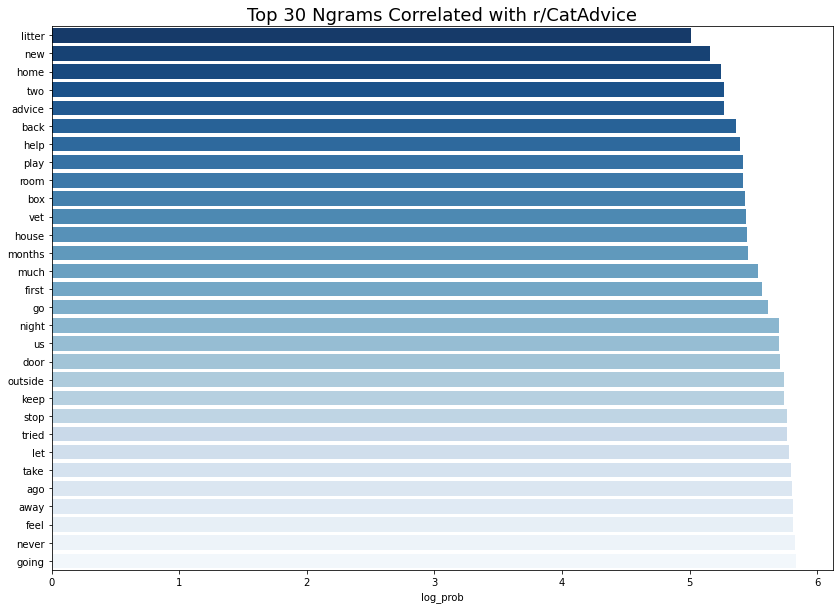

In [92]:
plt.figure(figsize=(14,10))
sns.barplot(data=cat_df.iloc[0:30,:], x=-cat_df.iloc[0:30,:]['log_prob'], y=cat_df.iloc[0:30,:]['feature'], palette='Blues_r')
plt.ylabel('')
plt.title('Top 30 Ngrams Correlated with r/CatAdvice', fontsize=18)
plt.show()

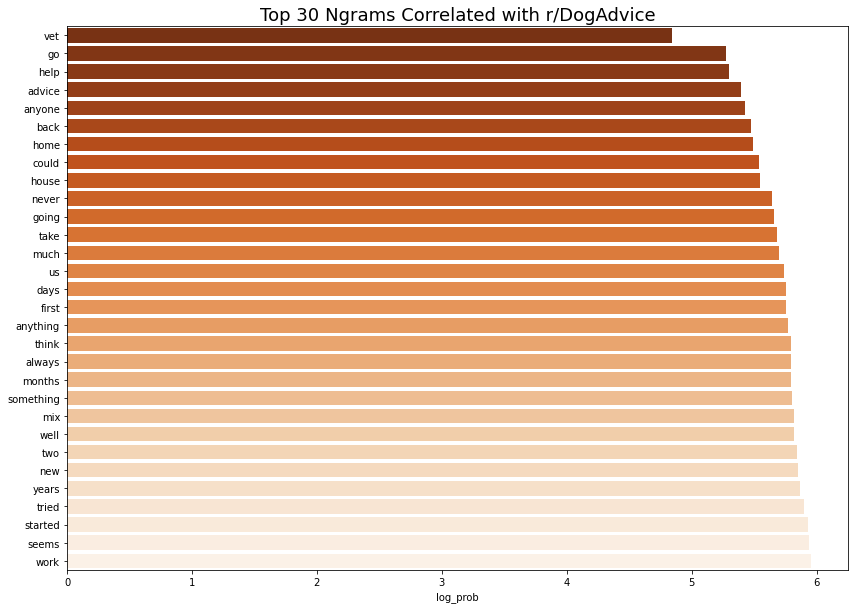

In [93]:
plt.figure(figsize=(14,10))
sns.barplot(data=dog_df.iloc[0:30,:], x=-dog_df.iloc[0:30,:]['log_prob'], y=dog_df.iloc[0:30,:]['feature'], palette='Oranges_r')
plt.ylabel('')
plt.title('Top 30 Ngrams Correlated with r/DogAdvice', fontsize=18)
plt.show()

Based on the top keywords, the best one-word keyword that describes r/CatAdvice would be: "litter". We notice a number of environment-related words, such as "home", "house", "room", "new", "outside" - indicating the users are concerned about their cats' behavior or reaction in the environment. 

Meanwhile keywords for r/DogAdvice, - the most indicative keywords are "vet" and "advice", but not much about dog's behavior or training which we saw from earlier EDA. We probably need more information from this subreddit to be able to generate more defined keywords.

Let's take a look at the wordcloud and see if we spot anything different.

In [94]:
from wordcloud import WordCloud

In [95]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20,14))
    plt.imshow(wordcloud)
    plt.axis("off");

In [96]:
catadv_posts = list(pets_df[pets_df['is_cat'] == 1]['cleaned_text'])
dogadv_posts = list(pets_df[pets_df['is_cat'] == 0]['cleaned_text'])

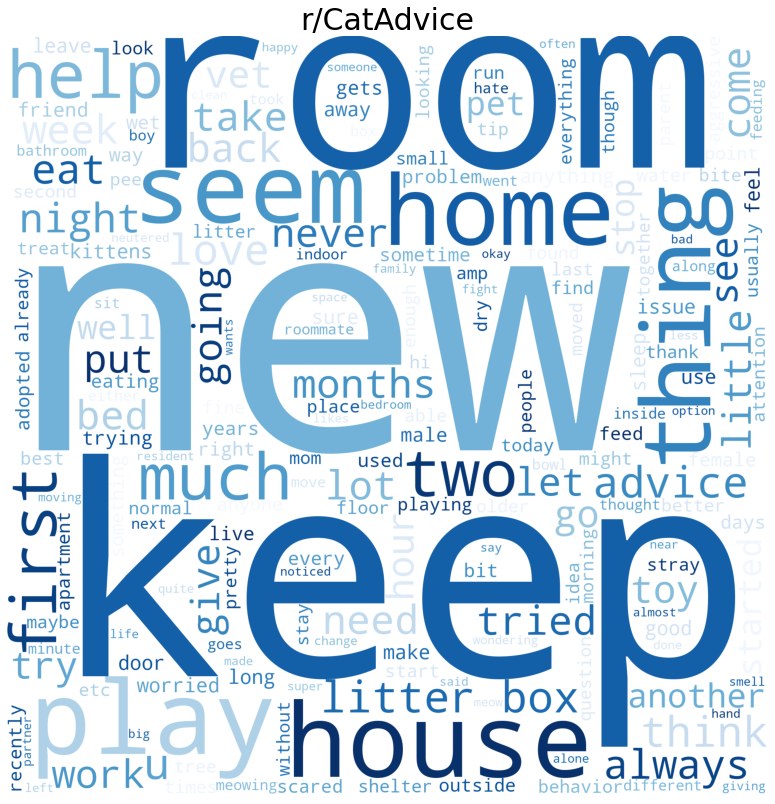

In [97]:
catadv_wordcloud = WordCloud(
        width = 2000, height = 2000, random_state = 10,
        background_color = 'white', colormap = 'Blues',
        max_font_size = 900).generate(' '.join(catadv_posts))

plot_cloud(catadv_wordcloud)
plt.title('r/CatAdvice', fontsize=30)
plt.show()

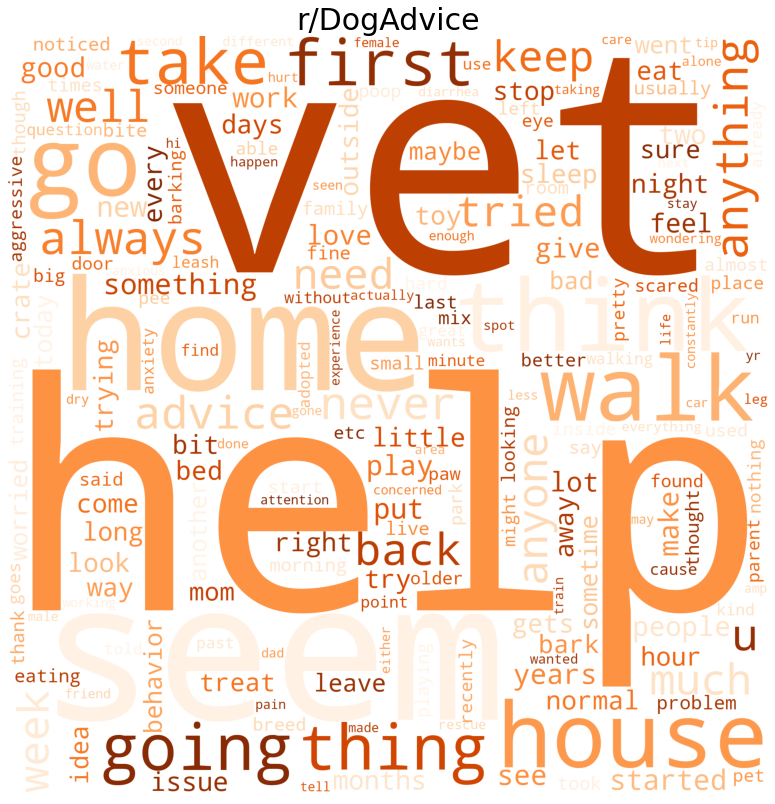

In [98]:
dogadv_wordcloud = WordCloud(
        width = 2000, height = 2000, random_state = 10,
        background_color = 'white', colormap = 'Oranges',
        max_font_size = 900).generate(' '.join(dogadv_posts))

plot_cloud(dogadv_wordcloud)
plt.title('r/DogAdvice', fontsize=30)
plt.show()

Similarly, even in the wordclouds -
- Words in r/CatAdvice that clearly indicate that it's a cat-related post are "kittens", "stray", "litter" and "litter box"
- Words in r/CatAdvice are mostly about the environment, e.g. "house", "home"
- Meanwhile we see more words in r/DogAdvice that appear to be more related to dogs, such as "walk", "leash", "bark", "treat"
- Only through the wordcloud, we're able to see a few words related to behavior and training such as "behavior", "aggressive", "bit", "training"

### Most accurately classified posts

To better understand why these words emerged as the top posts, let's take a closer look at the posts that had the highest prediction accuracy:

In [99]:
predictions = pd.DataFrame(gs3_model.predict_proba(X))
predictions.columns = ['is_dog', 'is_cat']
predictions['text'] = pets_df['cleaned_text']
predictions['predicted'] = gs3_model.predict(X)
predictions['actual'] = pets_df['is_cat']

In [100]:
predictions.sort_values('is_cat', ascending=False)[:10]

,is_dog,is_cat,text,predicted,actual
2508,6.561028e-22,1.0,update elimination issues dilemma posted biscuit https www reddit com r catadvice comments w wt r advice needed refuses consistently use utm source share amp utm medium web x amp context received lots suggestions advice fellow lovers unfortunately suggested changes interventions worked predicament facing additional issues biscuit escalated peeing things basement lock basement guide use litter boxes upstairs leopold took stride biscuit continued pee floor first least right area quickly moved wherever house wanted couple days pee floor right front us resigned decided could take right decided noticed blood tinged urine immediately took vet took sample came back positive oxalate crystals asked vet resolving fix elimination issues replied might might asked something could along said possible unlikely suggested change give months knowing absolutely survive months peeing house partner built two level house litter box area could put separate room cou...,1,1
145,2.704571e-14,1.0,tearing home husband years ago ended ago work feel heads tore entire bottoms brand new couches climb inside use scratching post despite several actual scratching posts towers house constantly brush vacuum house feel house coated fur disgusting invite anyone proofed everything curtains tear trying window tore many blinds leave rigged baby gate front stairs love rip carpet stairs decorations leave anything without knocked floor chewed replace expensive appliances due chewing cords tried bitter spray work tons toys play laser pointers aside great younger super sweet stranger tries play friend older super attached hides anyone else sweethearts never bite scratch hiss us point feel comfortable home accommodate every single thing behavior mom wants thought letting younger worry attached used well breaks heart think trying rehome either sorry post long hopefully someone reads relate words wisdom,1,1
2410,5.232223e-31,1.0,introductions mnth yr positive outcome stories confident already week new came home st months name october new coming shell basecamp play room october backstory october og stray shows signs cautious nervous first days hid within room note following jackson galaxy guide introductions past days comes walk room loves pet loves play eats treats hand however shown signs wanting explore house sometimes runs bed open door comes runs heard scratch meow door try dart yr minda tends hiss growl crack door instantly runs spots peek outside door go leave sometimes walks back door hisses underneath seems cautious walks door minda backstory grew gone yr weeks experience however back dad married girl two minda growl hiss chase point hide hardly come afraid treat october bc grew first stages keep basecamp scent swapping shown signs wanting sight swap yet worried point show signs wanting explore ik week first moved new trailer...,1,1
212,7.283219e-18,1.0,struggling ignoring legitimate playtime night hey brother sister pair spayed neutered delightful deeply loving boy energetic definitely needs wants attention keeping safe room overnight adopting months water toys bedding etc trying transition letting run house overnight live decently sized apartment gotten hang falling asleep foot bed every night thus far two things happen start purring standing heads chest wake us dealing either fully ignoring wordlessly moving back end bed bed initiate playing morning raced house half hour final lap taking place bed every minutes land bed tear across legs race back room seem concerned us e specifically attention seeking made unsure apply jackson galaxy ignore method eventually husband quietly closed bedroom door complain shutting playing giving attention trying consistent approach hang things cut nighttime wake ups terrible little cranky week,1,1
1730,1.215402e-33,1.0,litter box placement hello everyone couple days ago approved adopt wonderful little currently process everything ready comes home thing little unsure though roo

Our model is able to capture the posts from r/CatAdvice quite accurately - especially with the keywords we saw from the bar charts and wordcloud. Most evident keywords consistent in most of the top 10 posts above are: "kittens" and "litter box".

In [101]:
predictions

,is_dog,is_cat,text,predicted,actual
0,0.999946,5.386976e-05,cruel let die home bf believe currently dying decline severe sudden past days went seeming little bit barely breathing went vet yesterday told wrong look good best could running tests figure start warned likely treatable given symptoms us laid unexpectedly last cash went exam meds yesterday cheapest euthanasia price found calling belongs bf absolutely devastated trying figure never head spinning whole thing came nowhere understand things went downhill fast think sure rescue right made comfortable possible pain heart rate low bpm breathing fast shallow heartbroken help kindness advice go long way us right,0,1
1,0.580369,4.196314e-01,recommendations soft stool,0,1
2,0.275229,7.247714e-01,mo attachment issues starting stress,1,1
3,0.089847,9.101531e-01,absolute nightmare done everything book breaks everything bites keeps us night,1,1
4,0.434232,5.657677e-01,often pee,1,1
...,...,...,...,...,...
4094,1.000000,4.727689e-12,female jack russell metallic smell coming bum hello please help vet wants charge dollars exam insurance cover realize probably coming anal glands anyone else experienced always boy jrts first female always thought anal gland smell fishy think extremely metallic fixed menstrual cycle maybe wrong bleeding abnormally couple days ago noticed brownish spot pillow sleeping smell blood mixed something else explain tonight sleeping lap spot shorts thing night anal glands possibly infected helicopter parent unrelated note possibly throwing lot week diarrhea tuesday thursday night throwing well rush er friday trying throw collapsed floor move er nothing happened vitals normal bp hr temp good energy totally fine lost going take medications always cooked eat things ground last thing promise different neighbors live small complex many spots business happened sick week symptoms part diarrhea vomiting possible hoa sprayed something making s...,0,0
4095,0.000472,9.995282e-01,please roast hesitant post clue drink water bowl noticed weeks ago drink put filtered water bowl okay fair tap water city gross drink cup holding always drink cups cute first legitimately cannot drink unless give cup gotten point dehydrated barley urinating drinking enough throughout water bowl wont touch glass water gulps least half cup go tips,1,0
4096,0.439880,5.601202e-01,sudden aggression two together roughly years least troubles week ago runt less dominant started aggressive growling barking well outright attacking nothing seperating far left field hour ago newly aggressive drew blood attack us pretty docile lap otherwise cause sudden change way deal permanently separate life far back remember never seen happen,1,0
4097,0.981166,1.883360e-02,confidence building ways build confidence,0,0


In [102]:
predictions.sort_values('is_dog', ascending=False)[:10]

,is_dog,is_cat,text,predicted,actual
3795,1.0,2.913414e-15,reluctant eater past week yo cairn terrier x fussy eater meal sits almost next mealtime reluctantly eats hand tonight interested hand teeth fine drinking water belly feel tender tried swapping dry wet bland vet gave us tummy troubles found kfc park interested happy treats walks gave raw chicken wing sunday ate gusto eaten couple zucchini scraps piece steamed pumpkin tonight put meal snuffle mat kong bowl interested normally fast eater gets grain free dry hour long walk work work home give wet kong lunch anyone experience worried earliest vet appointment wednesday thanks reading,0,0
3870,1.0,3.791143e-18,might keep limping help jack russell spaniel x years kg healthy weight taken vets four times last almost always stops limping costing fortune pointless vet visits recent vet gave thorough manipulation pulling leg back moving pushing fingers flanks hips nothing looking vet say wtf dude usually longer walk park rather round houses sometimes afterwards jump bed limps withdrawn yelps loudly try pick seems last longer longer take vet nothing stressing vet says arthritis hip come nothing broken everything prescribed anti inflammatory medicine feel vets taking seriously push,0,0
3778,1.0,5.074498e-15,suggestions buying muzzle please read explanation actual questions bottom rest explaining think might need muzzle walks long sorry charlie pretty reactionary loves visiting people skittish needs energy backyard fine needs luckily live good neighborhood walking lot trees give shade neighbors typically friendly park close two main problems though people leash colony feral lot factors go first problem explain needed keep concise top easily break fences b c neighborhood kind fences fallen disrepair lot feral neighborhood neighbor backyard overgrown actually live house tall grass overgrown bushes perfect place hunt mice small prey near house lot charlie prey drive absolutely charlie catch kind roam neighborhood hard avoid charlie lbs kg kg overpower wants yet obvious solutions able walk neighborhood parks daycares charlie well park stresses amp ppl always watch usually take daycare expensive afford another play som...,0,0
3776,1.0,7.963253e-20,itching apoquel cytopoint years later hi yr mini dachshund apoquel daily yrs due itching skin point lose hair underarms ears worked fairly well however scratched eye bad pulled third eyelid looked cherry eye used able massage back per vets instructions however popped inflamed popped back operated two row stitches recent weeks itching gotten bad terrified hurting eye badly brought vet today take eyes instead walking blow donuts attach face eyes vet gave shot cytopoint see things ease hrs dragging face along ground ensured vet check eyes teeth case anything bothering physically good comfortable ideas vet told us could allergic grass dust mites etc made sure rinse dry kibble feeling deflated love stop attacking,0,0
3268,1.0,2.740913e-27,witnessed neighbor fight seems pretty wounded neighbor coming back monday neighbor two males greek shepherds always garden big garden build house seem weird relationship minute cuddling next fighting common fight usually starts something triggers bark thing animal sound triggered somehow end fighting pretty bad talked neighbor seemed consider normal thing big deal tonight walking unfortunately avoid house pass makes bark sometimes leads fighting every passed ran rails started barking started fighting put paid mind moved seen fighting however returned walk minutes later saw concerned lying standing top nothing standing standing saw us ran rails bark us usually move kept laying moving eyes look walked closer saw blood side neck tell bad wound dark moving nothing eyes looking scared makes believe quite bad neighbor home usually away weekends returns monday tuesday way contact number despite searching social media find profile matching name...,0,0
3459,1.0,1.012027e-16,anyone familiar reoccurring hge yo acd mix pretty hi

For r/DogAdvice, the word "vet" is present in nearly all of the posts - it seems like the users have already resorted to vets most of the time and end up turning to the subreddit when they couldn't figure out the solution. Furthermore, we noticed that most of the posts would name the dog's breed which may explain why the top words we saw were not very obvious.

### Misclassified posts

Now let's take a look at the posts that were wrongly classified:

In [103]:
wrong_predictions = predictions[predictions['predicted']!=predictions['actual']]

In [104]:
wrong_predictions

,is_dog,is_cat,text,predicted,actual
0,0.999946,0.000054,cruel let die home bf believe currently dying decline severe sudden past days went seeming little bit barely breathing went vet yesterday told wrong look good best could running tests figure start warned likely treatable given symptoms us laid unexpectedly last cash went exam meds yesterday cheapest euthanasia price found calling belongs bf absolutely devastated trying figure never head spinning whole thing came nowhere understand things went downhill fast think sure rescue right made comfortable possible pain heart rate low bpm breathing fast shallow heartbroken help kindness advice go long way us right,0,1
1,0.580369,0.419631,recommendations soft stool,0,1
17,0.680565,0.319435,harness training help,0,1
22,0.861543,0.138457,help cone due ear mites,0,1
23,0.719094,0.280906,help cone ear mite advice,0,1
...,...,...,...,...,...
4074,0.347918,0.652082,mental stimulation tire starting dark early live walk night hour walk gets zoomies favorite mental stimulation enrichment,1,0
4079,0.462797,0.537203,boi attacked fellow,1,0
4085,0.000038,0.999962,somewhat strange behavior night post golden retriever adopted february name riley sweetest girl however last week two sudden unusual behavior night odd general odd completely norm usually night routine soon turn shower start ready bed comes bedroom hops bed waits bed cuddle sleep night usually always stay bed night maybe move onto floor last week two started starting come bed stay couch living room fine couple nights started waking night pacing throughout living room kitchen nails clacking hard wood floors wake either come running jump bed wake morning go door let let runs yard pees runs back right away trying sniff mess usually sleep night issues wait morning finding behavior bit strange lately think type behavioral issue could sign something physical going seems otherwise healthy normal concerns nighttime behavior starting become bit odd especially randomly started recently affecting sleep night anyone thoughts advice,1,0
4095,0.000472,0.999528,please roast hesitant post clue drink water bowl noticed weeks ago drink put filtered water bowl okay fair tap water city gross drink cup holding always drink cups cute first legitimately cannot drink unless give cup gotten point dehydrated barley urinating drinking enough throughout water bowl wont touch glass water gulps least half cup go tips,1,0


There are 423 misclassified posts, out of 4,099. This is around 10% of the posts - which is a relatively small number and acceptable for our model performance.

Let's look at the cat posts that were classified as dog posts.

In [105]:
wrong_predictions[(wrong_predictions['is_dog'] > 0.95) & (wrong_predictions['actual'] == 1)]

,is_dog,is_cat,text,predicted,actual
0,0.999946,5.386976e-05,cruel let die home bf believe currently dying decline severe sudden past days went seeming little bit barely breathing went vet yesterday told wrong look good best could running tests figure start warned likely treatable given symptoms us laid unexpectedly last cash went exam meds yesterday cheapest euthanasia price found calling belongs bf absolutely devastated trying figure never head spinning whole thing came nowhere understand things went downhill fast think sure rescue right made comfortable possible pain heart rate low bpm breathing fast shallow heartbroken help kindness advice go long way us right,0,1
136,0.976206,2.379381e-02,falls asleep harness hi bowie months leash training going better longer whips tail walk run bit jumping playing slow well squating loses balance last times noticed whenever wearing harness falls asleep normal good thing depressed worried,0,1
245,0.973931,2.606904e-02,make calm doesnt harm surgery spayed amp shes always bery energetic wild expecting bit calm surgery anything shes wild anyone tips calm isnt risk,0,1
327,0.998604,1.395907e-03,could right poorly possible giardia noticed poorly involuntary muscle spasms seems lying twitches sleep worried honestly small little moments tenses releases mean right purring away times laying seem matter minor movement leg kinda moves little see generally tense little seems happen legs seem pain anything lay probably mins every tense seconds apart seems unbuffered,0,1
437,0.999984,1.595024e-05,lump lip worried recently noticed something bottom lip little lump sure worried years google telling cancer helping whatsoever came taken vet yet maybe first saw weeks ago first week quite small barely noticeable size newborns pinky good opinion see maybe someone knows might far seem bothering yet probably right place kind question worth try ask,0,1
612,0.987694,1.230571e-02,pancreatitis already took poor baby vet twice fluids pain medication appetite stimulant shot antibiotics fever sleeping alone eat four days advice offer goes much longer looking hospitalized vets sf area expensive anyone advice much appreciated,0,1
848,0.999788,2.118720e-04,sort bump lip bump lip noticed new looked pics add picture look sort fluid pink pimples idk pls help,0,1
891,0.981814,1.818582e-02,clean skin fur flea worm treatment,0,1
1008,0.998402,1.597977e-03,tell feeling better sick bear currently uri well bacterial overgrowth bowels went vet wednesday check put antibiotics probiotics issues eating drinking regularly today zoomies minutes signs medicines working recovering,0,1
1038,0.965402,3.459823e-02,affordable effective way treat feline asthma taken vet many times asthma seem liquid prednisone taking helping vet suggested steroid inhaler price tag little high willing pay treat see much feedback online inhaler skeptical continued use steroids extend life asthma shorten daily steroid use either especially seem working side note initially thought allergy coughing coupled constipation eating nutro vet switched royal canin gastrointestinal high fiber said give teaspoon miralax daily poops less flat gave miralax months discontinued concerned side effects long use change stool coughing stopping feel vet could put bandaid things allergy could underlying issue sharing details case anyone something similar thanks reading,0,1


Interestingly, the cat posts that were wrongly classified usually has the words "vet", "leash" and "paws" - which the model assumed were dog-related posts.

In [106]:
wrong_predictions[(wrong_predictions['is_cat'] > 0.95) & (wrong_predictions['actual'] == 0)]

,is_dog,is_cat,text,predicted,actual
2764,5.847419e-10,1.000000,sleep deprived owner looking advice years recently started waking middle night sure boyfriend stays night sure relevant things tried tried taking outside bathroom later pm wake work long wait go bathroom make sure plenty water water bowl go bed cracked bedroom door open incase wants go explore sleeping stays room behavior looks wakes stare breathe heavily first usually wakes normal sign need go bathroom mom taken bathroom pees bit immediately wants go back inside continues wake first attempt wake proceed jump bed front paws wake starts trying wake hours wake work extra info case helpful breed husky health everything normal take regular vet check ups visits feeding times pm feeding schedule vet recommended questions ask tldr husky keeps waking hours obvious reason nothing tried fixed issue,1,0
2778,1.170627e-03,0.998829,need help scared aggressive buch n frise almost years extremely hard people people comfortable rest family parents recently kids handle tried keep away kids isolate scared future kids something upset hurt thinking giving older chill couple age fact made zero progression connecting others think possible second option kill shelter help better interactive love much think makes wanna cry think well importantly family well best option anything else,1,0
2800,2.233912e-02,0.977661,ollie portion enough feeding ollie fresh well happy however noticed always hungry lost lb last pomeranian wonder ollie portion enough much appreciated share experiences ollie thank advance,1,0
2842,3.651500e-03,0.996349,never wanted play bichon frise months game tag chase chases back hours play sessions far offered every toy sun enjoyed problem heavier side weight loss journey finely reached goal recently yay working maintaining correct weight means favorite toys try initiate play sometimes play often requests pets ends huge cuddle session cuddle almost likes laying lap work done watch tv ect mean play much keep looking options suggestions,1,0
2931,1.560081e-03,0.998440,week waking sleep itching hello week first night tonight pomerian boy watching past hours whilst sleeping keeps waking every minutes scratch changing positions sometimes completely lay somewhere else seems scratching keeping awake changing positions lot hopefully help worried able good sleep concerned normal thanks,1,0
2938,1.943763e-03,0.998056,introducing new help bought new today introduced older happy playful thing new terrified screaming soon saw advice please new trust scared thanks advance,1,0
3031,1.172003e-02,0.988280,girlfriend obsessive point concern hi everyone hope holiday great coming issue cannot find material dating july increasingly become obsessed went cute concerning jump minutes kind deal stop licking climbing face walk away keep tried ignoring keeping couch eye contact gets anxious obsessed recently start putting crate due unable eat conversations anymore something method reinforce okay behavior upset hate stress see gives partner able relax,1,0
3063,1.792114e-03,0.998208,past two days eat parents put wet dry sausage egg intice put bowls eat problem eat morning heated chorizo oil tore sausage tore put usual dry wet mixed together eaten almost always tendancy bits put bowl take feet away drop sometimes eats sometimes leaves never gets eaten first though big bits could eating seem half wrong,1,0
3067,4.449926e-02,0.955501,behaviour advice keep short months always timid anxious personality however noticed home female owner super clingy anxious away always staring laying relax avoids husband though husband always good husband alone sleeps chills people homes knows well completely relaxed plays babysit totally fine thing completely relaxed normal make super anxious clingy understand tia,1,0
3116,7.164088e-05,0.999928,introducing amp next boyfriend moving together f pearl cudi thinking renting townhome advice making work pearl long interaction sweet girl gets along idea cudi cudi husky territorial u

Overall we can see that these posts are obviously about dogs when the breed is included. Most of these misclassified posts typically are behavior-related - on sleeping, anxiety, fear. Likely the behavior-related words are too common and generalized between cats and dogs, resulting in the misclassification. 


## Additional References

**[Study explores pandemic-specific challenges of pet ownership](https://www.avma.org/news/study-explores-pandemic-specific-challenges-pet-ownership)**
- The article highlights a study conducted in the US, revealing that pets were a source of stress for owners during the pandemic. 
- I referred to this article to build a compelling story for the analysis as well as to strengthen the conclusion and recommendations. 

**[Reddit post property unofficial documentation](https://www.reddit.com/r/redditdev/comments/a1dn2p/any_documentation_on_post_properties_such_as/)**
- The subreddit discussion from r/redditdev covered unofficial documentation of the post properties and its definition.
- I referred to this post to narrow down the relevant features for investigation and analysis. 

## Limitations

When it comes to language and texts, it's always challenging trying to achieve near-perfect predictions on what users may say next, and what it would mean. The best way to improve our modeling outcome would be:
1. The subreddits we mined from were more focused on behavior and the environment surrounding the pets, perhaps we could consider working with moderator to run polls and prompt people to specify their exact challenges faced.
2. Alternatively, we could also work with moderators to ask users to include more information on their pets' breed, age, images, etc in their post so that there are more words we can work with.
3. Mine for data from different subreddits or forums, ideally on topics that are more polarizing so that we can train our model to better detect each topic. For example, pet medical vs pet training. 

## Conclusion

In summary, our model has helped address the challenges faced by the animal shelter:
1. Pet owners are primarily concerned with their pets' surrounding environment and training.
    - r/CatAdvice - owners are concerned with their cats' urinating outside the litter box and overall frequency. They are also worried about whether the cats are adapting well to the surrounding environment.
    - r/DogAdvice - in the EDA process we saw that owners mentioning that their dogs were acting strange but it wasn't clear on the exact behavior. However, following the modeling process we can see that most of the issues faced continue even after the owners have seen a vet - likely they are seeking second or third opinion from the subreddit. Interestingly, dog owners tend to elaborate on the details more and often mention their dogs' breed.
2. The most accurate prediction model is Naive Bayes, along with the Counter Vectorization. 
    - Based on our score, we can run this model on similar dataset that are specific to cat- and dog-related behaviors and general care.
    - For the animal shelter, this model will be able to help them better predict issues that potential owners will face and the concerns that they might have.

## Recommendation

Through this model, we would recommend that the animal shelter takes the following steps to improve pet owners' experience when it comes to training and creating an environment that works for the owners and pets. They can do this in the following phases:
- Before adoption: Provide a checklist to help new pet owners prepare and adjust, e.g. read up on the pet's breed and history, pet-proof their homes before bringing the new pet home, learn to communicate with their pets.
- During: Provide courses to help owners train their newly adopted pets and ensure that they bond.
- Post-adoption: Schedule check-ins on the progress and offer personalized support to help owners better train/care for their pets. Collect feedback on whether the previous support were sufficient.
    
The animal shelter can also collect more information new pet owners, which can be used to train and improve our model.